In [1]:
from cpclasses import *

In [2]:
lennard_jones_calc = LennardJones()
def create_initial_cluster(Nouter, Ninner, N_inner_inner, inner_circle = True, inner_inner_circle = True):

    thetas = np.linspace(0,2*np.pi,Nouter,endpoint=False)
    pos = [ Nouter / 2 / np.pi * np.array([np.cos(theta),np.sin(theta)]) for theta in thetas]
    
    static = [True for i in range(Nouter)]

    if inner_circle:
        thetas = np.linspace(0,2*np.pi,Ninner,endpoint=False)
        pos += [1.2* Ninner / 2 / np.pi * np.array([np.cos(theta),np.sin(theta)]) for theta in thetas]
        static += [False for i in range(Ninner)]

    if inner_inner_circle:
        thetas = np.linspace(0,2*np.pi,N_inner_inner,endpoint=False)
        pos += [1.2*1.2* N_inner_inner / 2 / np.pi * np.array([np.cos(theta),np.sin(theta)]) for theta in thetas]
        static += [False for i in range(N_inner_inner)]
    pos = np.array(pos)
    return AtomicCluster(lennard_jones_calc,pos=pos,
                         static=static)


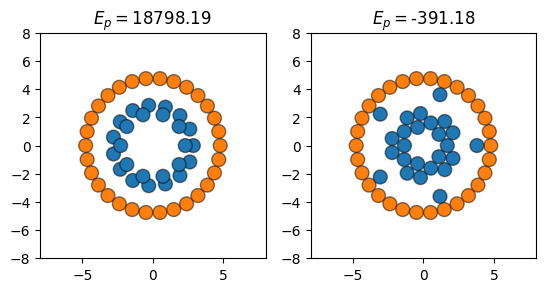

In [3]:
cluster = create_initial_cluster(30, 15, 10)

fig, axs = plt.subplots(1,2)
cluster.draw(axs[0])
axs[0].set(xlim = (-8,8), ylim = (-8,8), aspect='equal')


relax(cluster, 100)
cluster.draw(axs[1])
axs[1].set(xlim = (-8,8), ylim = (-8,8), aspect='equal')

save_plot(fig, 'initial_cluster.png')

In [4]:

def thermostat(system):
    v = system.get_velocities()
    v = np.sqrt(system.kT) * np.random.normal(size=v.shape)
    v = np.where(system.filter, 0, v)
    system.set_velocities(v)

In [5]:
def simulated_annealing(cluster, T0, Tf, nsteps):
    T = T0
    energies = []
    for i in range(nsteps):
        cluster.kT = T
        thermostat(cluster)
        velocity_verlet(cluster, 50,0.01)
        T = T0 * (Tf / T0) ** (i / nsteps)
        energies.append(cluster.potential_energy + cluster.kinetic_energy) 
    return cluster, energies


#simulated_annealing(cluster, 1, 0.01, 100)


In [6]:
#write an update function for animation, where it performs simulated annealing for a few steps and then plots the current state

def update(i):
    print(i)
    if i == 0:

        T = 0.01
       
    while i < 100:
        T0 = 0.01
        Tf = 1
        cluster.kT = T
        thermostat(cluster)
        velocity_verlet(cluster, 50,0.01)
        T = T0 * (Tf / T0) ** (i / 500)

    while i>=100:
        T0 = 1
        Tf = 0.01
        
        cluster.kT = T
        thermostat(cluster)
        velocity_verlet(cluster, 50,0.01)
        T = T0 * (Tf / T0) ** (i - 500 / 500)
    
        

        T0 = Tf

    if i%5 == 0:
        cluster.draw(ax)



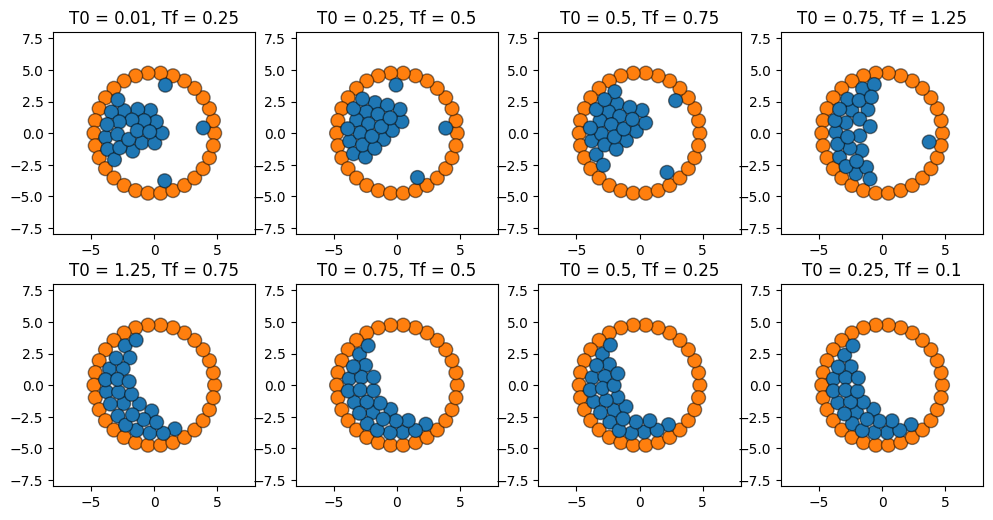

In [7]:
cluster = create_initial_cluster(30, 15, 10)
relax(cluster, 100, 0.01)

fig, axs = plt.subplots(2,4, figsize=(12,6))
temperatures0 = [0.01, 0.25, 0.5, 0.75, 1.25, 0.75, 0.5, 0.25]
temperaturef = [0.25, 0.5, 0.75, 1.25, 0.75, 0.5, 0.25, 0.1]

energies_all = []

for ax, T0, Tf in zip(axs.flatten(), temperatures0, temperaturef):
    ax.set(xlim = (-8,8), ylim = (-8,8), aspect='equal')
    cluster, energies = simulated_annealing(cluster, T0, Tf, 250)
    energies_all.append(energies)
    cluster.draw(ax)
    ax.set_title(f"T0 = {T0}, Tf = {Tf}")




In [8]:
save_plot(fig, "simulated_annealing.png")

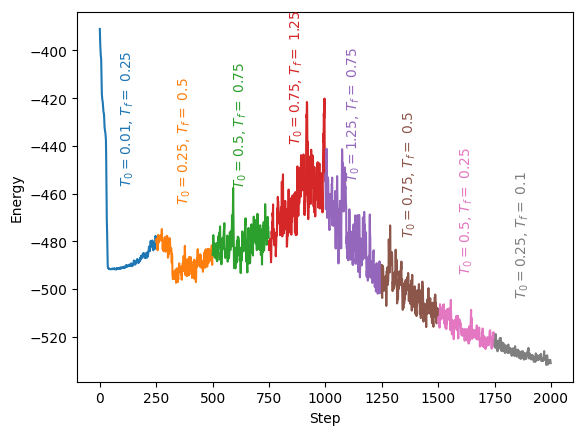

In [9]:
fig, ax = plt.subplots()


for i,energies in enumerate(energies_all):
    plot_range = range(i*250, (i+1)*250)
    ax.plot(plot_range, energies)
    ax.text((i+0.5)*250, np.mean(energies) + 25, r"$T_0 = $"+f'{temperatures0[i]},'+r' $T_f = $ '+f'{temperaturef[i]}', ha='center', rotation=90, color=f'C{i}')

ax.set(xlabel='Step', ylabel='Energy')


save_plot(fig, 'simulated_annealing, energies.png')